# Diffuion-based Data Augmentation

This is the initial implementation of DDA for Skin Cancer Detection of Images for generating synthetic images.

This was made possible through the tutorial and course of John Whitacker from Hugging Face: https://johnowhitaker.github.io/tglcourse/dm1.html.

Submitted by: \\
Westin Darren T. Maceda \\
Jela May B. Yap

## Setup and Imports:

In [ ]:
%pip install -q diffusers

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f'Using device: {device}')

Using device: cuda


## The Data

For initial model training, we will use the ISIC 2016 Dataset uploaded on our personal Gdrive account / Computer

In [ ]:
# # Mount the gdrive
# from google.colab import drive
# drive.mount('/content/drive')
# # change path
# %cd /content/drive/MyDrive/CS \198/Datasets/ISIC2016

In [ ]:
%cd D:\jelaa\datasets\ISIC2016

D:\jelaa\datasets\ISIC2016


C:\Users\Rhon\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
csv_file = 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
labels_df = pd.read_csv(csv_file, header=None, names=['image_id', 'label'])

label_map = {
    'benign': 0,
    'malignant': 1
}
labels_df['label'] = labels_df['label'].map(label_map)

image_dir = 'ISBI2016_ISIC_Part1_Training_Data'
labels_df['file_path'] = labels_df['image_id'].apply(lambda x: f"{image_dir}/{x}.jpg")
labels_df.head()

,image_id,label,file_path
0,ISIC_0000000,0,ISBI2016_ISIC_Part1_Training_Data/ISIC_0000000...
1,ISIC_0000001,0,ISBI2016_ISIC_Part1_Training_Data/ISIC_0000001...
2,ISIC_0000002,1,ISBI2016_ISIC_Part1_Training_Data/ISIC_0000002...
3,ISIC_0000004,1,ISBI2016_ISIC_Part1_Training_Data/ISIC_0000004...
4,ISIC_0000006,0,ISBI2016_ISIC_Part1_Training_Data/ISIC_0000006...


In [ ]:
# get only malignant as Dataset Class
malignant_images = labels_df[labels_df['label'] == 1]
img_size = 256

from torchvision import transforms

mean, std = [0.56719837, 0.61864448, 0.72383769], [0.15109317, 0.12867224, 0.10518483]

normalization = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ]
)

In [ ]:
class ISICDataset(Dataset):
    def __init__(self, labels_df, transform=None):
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = row['file_path']
        image = Image.open(img_path).convert("RGB")
        label = row['label']

        if self.transform:
            image = self.transform(image)

        return image, label

Input shape: torch.Size([5, 3, 256, 256])
Labels: tensor([1, 1, 1, 1, 1])


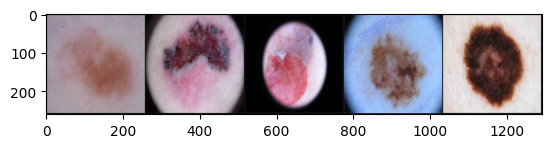

In [ ]:
# malignant_dataset = ISICDataset(malignant_images.iloc[[8,9,12,14,15]], transform=normalization)
malignant_dataset = ISICDataset(malignant_images[:5], transform=normalization)
train_dataloader = DataLoader(malignant_dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
# Create the image grid
grid_image = torchvision.utils.make_grid(x)

# Permute the grid to (H, W, C) for display with imshow
plt.imshow(grid_image.permute(1, 2, 0).cpu().numpy())

## The Corruption Process

Here we add gradually add noise to the malignant samples.

In [ ]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

And looking at the results visually to see that it works as expected:

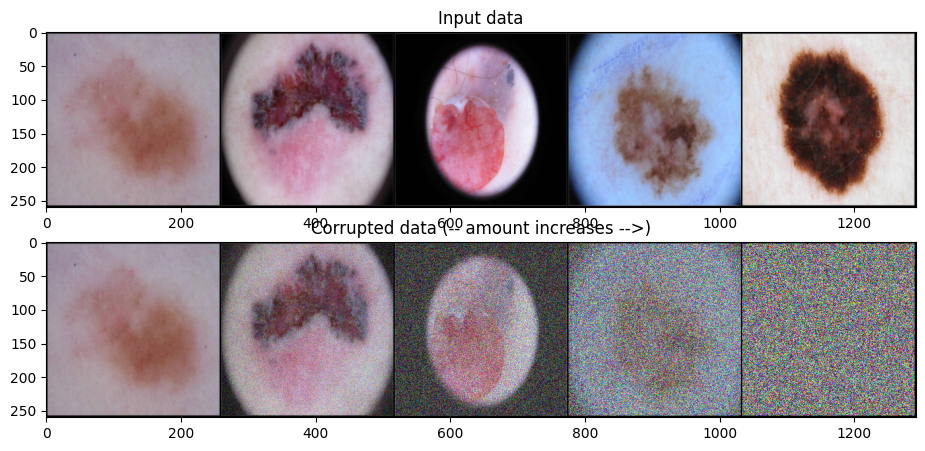

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x).permute(1, 2, 0).cpu().numpy())

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x).permute(1, 2, 0).cpu().numpy());

## Training the model

In [ ]:
# Dataloader
batch_size = 5
train_dataloader = DataLoader(malignant_dataset, batch_size=batch_size, shuffle=True)

# Epochs
n_epochs = 25

# Create the model
net = UNet2DModel(
    sample_size=img_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
)
net.to(device)

x = torch.rand(1, 3, img_size, img_size).to(device)
net(x, 1).sample.shape

torch.Size([1, 3, 256, 256])

Finished epoch 0. Average loss for this epoch: 0.392896
Finished epoch 1. Average loss for this epoch: 0.305477
Finished epoch 2. Average loss for this epoch: 0.231471
Finished epoch 3. Average loss for this epoch: 0.186517
Finished epoch 4. Average loss for this epoch: 0.139150
Finished epoch 5. Average loss for this epoch: 0.100304
Finished epoch 6. Average loss for this epoch: 0.090572
Finished epoch 7. Average loss for this epoch: 0.094922
Finished epoch 8. Average loss for this epoch: 0.057136
Finished epoch 9. Average loss for this epoch: 0.039690
Finished epoch 10. Average loss for this epoch: 0.060625
Finished epoch 11. Average loss for this epoch: 0.052770
Finished epoch 12. Average loss for this epoch: 0.042955
Finished epoch 13. Average loss for this epoch: 0.047662
Finished epoch 14. Average loss for this epoch: 0.032149
Finished epoch 15. Average loss for this epoch: 0.053469
Finished epoch 16. Average loss for this epoch: 0.049384
Finished epoch 17. Average loss for this 

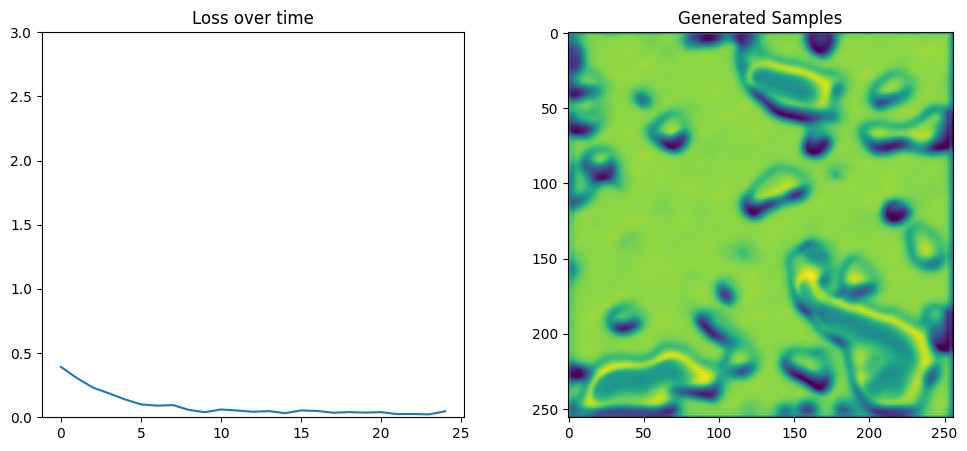

In [ ]:
# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 3.0)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(1, 3, img_size, img_size).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x, nrow=8)[0].unsqueeze(0).permute(1, 2, 0).cpu().clip(0, 255))
axs[1].set_title('Generated Samples');

image = x.cpu()[0]

# Access the values of each channel at a specific pixel location (e.g., (10, 20))
red_channel_value = image[0, 10, 20]
green_channel_value = image[1, 10, 20]
blue_channel_value = image[2, 10, 20]

print("Red channel value:", red_channel_value)
print("Green channel value:", green_channel_value)
print("Blue channel value:", blue_channel_value)

## Generation of Synthetic Samples

In [ ]:
# Samples
n_steps = 40
x = torch.rand(554, 3, img_size, img_size).to(device)

to_pil = torchvision.transforms.ToPILImage()

for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
  # Save each of the 3 images for this step

  if (i == n_steps - 1):
    for idx in range(x.shape[0]):  # Iterate through batch
        image = to_pil(torch.clamp(x[idx], 0, 1))  # Clamp to valid range [0, 1]
        image.save(f'image_{i+1:02d}_sample_{idx+1}.png')  # Save image with step and batch index